In [2]:
import pandas as pd
from multiprocessing import Pool
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 9

color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y',
    'red': 'r'
}

In [ ]:
# stim_ints = pd.read_csv('csvs/stimulus_intervals.csv', index_col=False)
# stim_ints['interval'] = stim_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
#                                                             pd.Timestamp(x.split(', ')[1].strip(')')), 
#                                                             closed='left'))

cam_ints = pd.read_csv('csvs/camera_intervals.csv', index_col=False)
cam_ints['interval'] = cam_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(']')), 
                                                            closed='both'))

bombus_visits = pd.read_csv('csvs/bombus_visit_durations.csv', index_col=False, parse_dates=['visit_start', 'visit_end'])
bombus_visits['interval'] = pd.IntervalIndex.from_arrays(bombus_visits['visit_start'], bombus_visits['visit_end'], closed='both')
bombus_visits

,species,visit_id,pi,color,visit_start,visit_end,duration,pi_color,interval
0,fervidus,67.0,9,grn,2024-07-11 07:28:42,2024-07-11 07:28:42,0.0,9_grn,"[2024-07-11 07:28:42, 2024-07-11 07:28:42]"
1,vosnesenskii,32.0,2,blv,2024-07-11 07:51:19,2024-07-11 07:51:19,0.0,2_blv,"[2024-07-11 07:51:19, 2024-07-11 07:51:19]"
2,vosnesenskii,79.0,6,cnt,2024-07-11 08:09:09,2024-07-11 08:09:09,0.0,6_cnt,"[2024-07-11 08:09:09, 2024-07-11 08:09:09]"
3,fervidus,28.0,4,grn,2024-07-11 08:40:37,2024-07-11 08:40:37,0.0,4_grn,"[2024-07-11 08:40:37, 2024-07-11 08:40:37]"
4,vosnesenskii,1.0,1,cnt,2024-07-11 08:43:51,2024-07-11 08:43:51,0.0,1_cnt,"[2024-07-11 08:43:51, 2024-07-11 08:43:51]"
...,...,...,...,...,...,...,...,...,...
290,fervidus,66.0,8,cnt,2024-08-25 13:35:59,2024-08-25 13:35:59,0.0,8_cnt,"[2024-08-25 13:35:59, 2024-08-25 13:35:59]"
291,vosnesenskii,31.0,1,blv,2024-09-05 07:39:55,2024-09-05 07:40:00,5.0,1_blv,"[2024-09-05 07:39:55, 2024-09-05 07:40:00]"
292,vosnesenskii,141.0,9,grn,2024-07-23 09:41:43,2024-07-23 10:02:38,1255.0,9_grn,"[2024-07-23 09:41:43, 2024-07-23 10:02:38]"
293,vosnesenskii,142.0,9,grn,2024-07-23 10:02:19,2024-07-23 10:07:09,290.0,9_grn,"[2024-07-23 10:02:19, 2024-07-23 10:07:09]"


In [141]:
# treatment_times = pd.read_csv('csvs/treatment_times_fixed.csv', index_col=False)
# treatment_times['datetime'] = pd.to_datetime(treatment_times['datetime'], format= "%Y-%m-%d %H:%M:%S")
# treatment_times = treatment_times.drop(columns='date')

In [142]:
# df = treatment_times.sort_values(by=['pi', 'color', 'datetime'])
# df['time_diff'] = df.groupby(['pi', 'color'])['datetime'].diff()
# df['new_period'] = (df['time_diff'] > pd.Timedelta(minutes=1)) | df['time_diff'].isna()
# df['period_id'] = df.groupby(['pi', 'color'])['new_period'].cumsum()
# cam_on = df.groupby(['pi', 'color', 'period_id']).agg(start_time=('datetime', 'min'), end_time=('datetime', 'max')).reset_index()



In [7]:
# color_map = {
#     'cnt': 'm',
#     'blu': 'b',
#     'blv': 'c',
#     'grn': 'g',
#     'yel': 'y'
# }

# fig, ax = plt.subplots(figsize=(12, 3))
# pi_values = {pi: i for i, pi in enumerate(cam_on['pi'].unique())}
# for idx, row in cam_on.iterrows():
#     y = pi_values[row['pi']]
#     color = color_map.get(row['color'])
#     ax.plot([row['start_time'], row['end_time']], [y, y], label=f"{row['color']} ({row['pi']})", color=color)

# ax.set_yticks(list(pi_values.values()))
# ax.set_yticklabels(list(pi_values.keys()))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)


In [4]:
# camera_timeline = treatment_times.copy()[['pi', 'datetime', 'color']]
# camera_timeline = camera_timeline.sort_values(by=['pi', 'datetime'])

# filled_df = pd.DataFrame(columns=camera_timeline.columns)
# for pi_val in camera_timeline['pi'].unique():
#     pi_data = camera_timeline[camera_timeline['pi'] == pi_val]
#     for i in range(len(pi_data) - 1):
#         current_time = pi_data.iloc[i]['datetime']
#         next_time = pi_data.iloc[i + 1]['datetime']
#         if (next_time - current_time).total_seconds() > 1 and (next_time - current_time).total_seconds() <= 10:
#             new_times = pd.date_range(start=current_time + pd.Timedelta(seconds=1),
#                                       end=next_time - pd.Timedelta(seconds=1), freq='S')
#             new_rows = pd.DataFrame({'pi': [pi_val] * len(new_times), 'datetime': new_times})
#             filled_df = pd.concat([filled_df, new_rows], ignore_index=True)
#     filled_df = pd.concat([filled_df, pi_data], ignore_index=True)

# filled_df = filled_df.sort_values(by=['pi', 'datetime']).reset_index(drop=True)

# filled_df




In [5]:
# def process_pi(pi_val):
#     pi_data = camera_timeline[camera_timeline['pi'] == pi_val]
#     filled_pi_df = pd.DataFrame(columns=camera_timeline.columns)
#     for i in range(len(pi_data) - 1):
#         current_time = pi_data.iloc[i]['datetime']
#         next_time = pi_data.iloc[i + 1]['datetime']
#         if 1 < (next_time - current_time).total_seconds() <= 10:
#             new_times = pd.date_range(start=current_time + pd.Timedelta(seconds=1),
#                                       end=next_time - pd.Timedelta(seconds=1), freq='S')
#             new_rows = pd.DataFrame({'pi': [pi_val] * len(new_times), 'datetime': new_times})
#             filled_pi_df = pd.concat([filled_pi_df, new_rows], ignore_index=True)
#     return pd.concat([filled_pi_df, pi_data], ignore_index=True)

# with Pool(processes=10) as pool:
#     results = pool.map(process_pi, camera_timeline['pi'].unique())

# filled_df = pd.concat(results, ignore_index=True)
# filled_df = filled_df.sort_values(by=['pi', 'datetime']).reset_index(drop=True)




In [6]:
# filled_df.to_csv('csvs/camera_timeline.csv', index=False)

# camera_timeline = pd.read_csv('csvs/camera_timeline.csv')
# camera_timeline['datetime'] = pd.to_datetime(camera_timeline['datetime'])
# camera_timeline = pd.merge(camera_timeline, treatment_times[['pi', 'datetime', 'color']], on=['pi', 'datetime'], how='left')

In [7]:
# camera_timeline['color_ffill'] = camera_timeline['color'].ffill()
# camera_timeline['color_bfill'] = camera_timeline['color'].bfill()

# camera_timeline['datetime_ffill'] = camera_timeline['datetime'].where(camera_timeline['color'].notna()).ffill()
# camera_timeline['datetime_bfill'] = camera_timeline['datetime'].where(camera_timeline['color'].notna()).bfill()

# def nearest_color(row):
#     if pd.isna(row['color']):
#         delta_forward = abs(row['datetime'] - row['datetime_ffill'])
#         delta_backward = abs(row['datetime'] - row['datetime_bfill'])
#         if delta_forward <= delta_backward:
#             return row['color_ffill']
#         else:
#             return row['color_bfill']
#     else:
#         return row['color']

# camera_timeline['color'] = camera_timeline.apply(nearest_color, axis=1)

# camera_timeline.drop(['color_ffill', 'color_bfill', 'datetime_ffill', 'datetime_bfill'], axis=1, inplace=True)



In [8]:
# camera_timeline.to_csv('csvs/camera_timeline.csv', index=False)

In [9]:
# camera_timeline = pd.read_csv('csvs/camera_timeline.csv')
# camera_timeline['datetime'] = pd.to_datetime(camera_timeline['datetime'])

In [58]:
# color_map = {
#     'cnt': 'm',
#     'blu': 'b',
#     'blv': 'c',
#     'grn': 'g',
#     'yel': 'y'
# }

# mapped_colors = camera_timeline['color'].map(color_map)


# fig, ax = plt.subplots(figsize=(30, 3))

# plt.scatter(camera_timeline['datetime'], camera_timeline['pi'], marker='|', c=mapped_colors)

In [11]:
# bombus_df = pd.read_csv('csvs/clean_dfs/bombus_df.csv')
# bombus_df['datetime'] = pd.to_datetime(bombus_df['datetime'])
# bombus_df = pd.merge(bombus_df, treatment_times[['pi', 'datetime', 'color']], on=['pi', 'datetime'], how='left')
# bombus_df['new_visit'] = (bombus_df['time_diff'] > 4) | (bombus_df['time_diff'].isna())
# bombus_df['visit_id'] = bombus_df.groupby(['species'])['new_visit'].cumsum()

# visit_durations = (
#     bombus_df.groupby(['species', 'visit_id', 'pi', 'color'])['datetime']
#     .agg(visit_start='min', visit_end='max')
#     .reset_index()
# )
# visit_durations['duration'] = (
#     (visit_durations['visit_end'] - visit_durations['visit_start']).dt.total_seconds()
# )

In [15]:
# visit_times = visit_durations[['visit_start', 'visit_end']]
# visit_times

In [58]:
def run_simulation(cam_ints, bombus_visits):
    visit_dict = {}
    bombus_visits['pi'] = np.random.randint(1, 11, len(bombus_visits))

    color_counts = pd.Series(dtype=int)
    for i, visit in bombus_visits.iterrows():
        pi = visit['pi']
        visit_interval = visit['interval']
        relevant_cams = cam_ints[cam_ints['pi'] == pi]
        assigned = False

        for _, cam in relevant_cams.iterrows():
            cam_interval = cam['interval']
            if visit_interval.overlaps(cam_interval):
                color = cam['color']
                visit_dict[i] = {'visit_start': visit_interval.left, 'pi': pi, 'color': color}
                if color in color_counts:
                    color_counts[color] += 1
                else:
                    color_counts[color] = 1
                assigned = True
        if not assigned:
            visit_dict[i] = {'visit_start': visit_interval.left, 'pi': pi, 'color': 'red'}

    return color_counts, visit_dict

visit_counts, visit_dict = run_simulation(cam_ints, bombus_visits)
print(f'total captured visits: {sum(visit_counts)}')
visit_counts


total captured visits: 257


cnt    52
blv    48
yel    55
grn    64
blu    38
dtype: int64

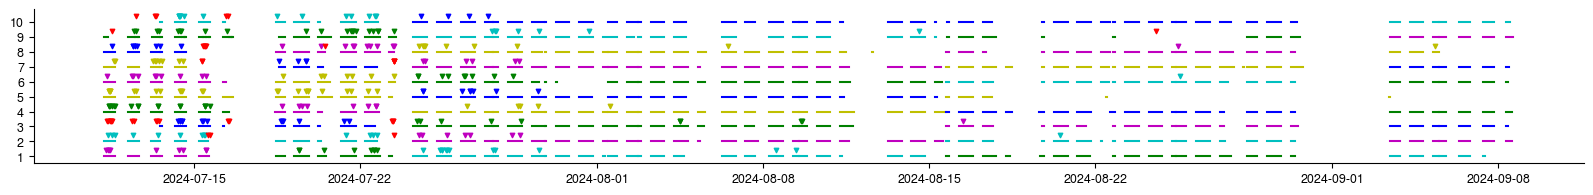

In [59]:
fig, ax = plt.subplots(figsize=(20, 2))
for i, row in cam_ints.iterrows():
    start = row['interval'].left
    end = row['interval'].right
    color = color_map[row['color']]
    pi = row['pi']
    ax.plot([start, end], [pi, pi], color=color)

for key, entry in visit_dict.items():
    visit_start = entry['visit_start']
    pi = entry['pi']
    color = color_map.get(entry['color'])
    ax.scatter(visit_start, pi+.4 , color=color, marker='v', s=10, zorder=3)

ax.set_yticks(np.arange(1,11))
ax.set_yticklabels(np.arange(1,11))
plt.show()

In [ ]:
def run_simulation(cam_on, visit_times, iterations=1):
    results = []

    for _ in range(iterations):
        visit_times['pi'] = np.random.randint(1, 11, len(visit_times))
        color_counts = pd.Series(dtype=int)
        for _, visit in visit_times.iterrows():
            pi = visit['pi']
            visit_interval = visit['interval']
            relevant_cams = cam_on[cam_on['pi'] == pi]

            for _, cam in relevant_cams.iterrows():
                cam_interval = cam['interval']
                if visit_interval.overlaps(cam_interval):
                    color = cam['color']
                    color_counts[color] = color_counts.get(color, 0) + 1

        results.append(color_counts)

    final_results = pd.concat(results, axis=1).fillna(0).astype(int).T

    return final_results

simulation_results = run_simulation(cam_ints, bombus_visits, iterations=1000)

,blu,cnt,yel,grn,blv
0,47,43,53,65,48
1,39,56,53,53,54
2,45,55,45,64,51
3,45,59,52,44,63
4,42,61,58,48,55
...,...,...,...,...,...
995,34,56,63,53,44
996,43,66,48,50,44
997,49,56,71,47,43
998,55,52,52,51,37


In [62]:
from joblib import Parallel, delayed

def single_simulation(cam_on, visit_times):
    visit_times = visit_times.copy()
    visit_times['pi'] = np.random.randint(1, 11, len(visit_times))
    color_counts = pd.Series(dtype=int)

    for _, visit in visit_times.iterrows():
        pi = visit['pi']
        visit_interval = visit['interval']
        relevant_cams = cam_on[cam_on['pi'] == pi]

        for _, cam in relevant_cams.iterrows():
            cam_interval = cam['interval']
            if visit_interval.overlaps(cam_interval):
                color = cam['color']
                color_counts[color] = color_counts.get(color, 0) + 1

    return color_counts

def run_simulation_parallel(cam_on, visit_times, iterations=1000, num_jobs=-1):
    results = Parallel(n_jobs=num_jobs)(
        delayed(single_simulation)(cam_on, visit_times) for _ in range(iterations)
    )

    final_results = pd.concat(results, axis=1).fillna(0).astype(int).T
    return final_results

simulation_results_parallel = run_simulation_parallel(cam_ints, bombus_visits, iterations=1000)

In [137]:
simulation_results.to_csv('simresults_int_10000.csv', index=False)

43.723
56.439
53.791
53.919
47.062


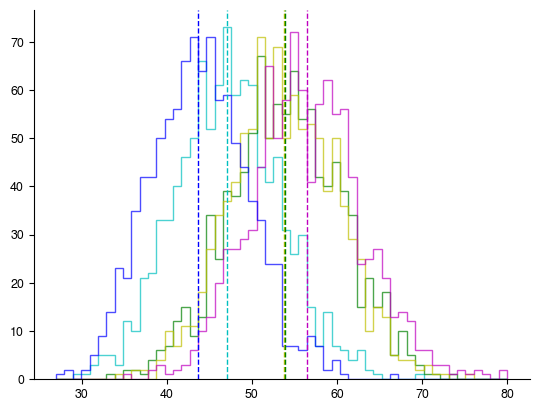

In [64]:
colors = [color_map[col] for col in simulation_results.columns]
plt.hist(simulation_results.values, bins=simulation_results.values.max() - simulation_results.values.min()+1, color=colors, histtype='step', alpha=0.7)
for col, color in zip(simulation_results.columns, colors):
    plt.axvline(simulation_results[col].mean(), color=color, linestyle='dashed', linewidth=1)
    print(simulation_results[col].mean())

plt.show()